In [165]:
import numpy as np
import matplotlib.pyplot as plt

In [166]:
class RandomAction:
    def __init__(self, n_states=1000, left_reward=-1):
        self.n_states = n_states
        self.left_reward = left_reward
        self.reset()

    def reset(self):
        self.state = self.n_states // 2
        return self.state

    def step(self):
        action = 0
        while action == 0:
            action = np.random.randint(-100, 101)

        self.state += action

        if self.state < 0:
            return self.state, self.left_reward, True
        elif self.state >= self.n_states:
            return self.state, 1, True
        return self.state, 0, False

In [167]:
V = np.zeros(1000)
N = np.zeros(1000)

episodes = 100000
alpha = 2e-5

FIRST_VISIT = False

env = RandomAction()

for episode in range(episodes):
    state = env.reset()

    states = []
    rewards = []

    done = False

    while not done:
        states.append(state)
        state, reward, done = env.step()
        rewards.append(reward)
        
    G = 0
    for i in reversed(range(len(states))):
        if not FIRST_VISIT or states[i] not in states[:i]:
            G = G + rewards[i]
            N[states[i]] += 1
            V[states[i]] += (G - V[states[i]]) / N[states[i]]

In [168]:
class TileCoding:
    def __init__(self, tile_width, n_tiles, n_slices, tile_gap, alpha, do=False):
        self.n_tiles = n_tiles
        self.n_slices = n_slices
        self.tile_gap = tile_gap
        self.tile_width = tile_width
        self.alpha = alpha
        self.tile = []
        for i in range(n_tiles):
            tile_index = []
            for j in range(n_slices):
                tile_index.append(-i * tile_gap + j * tile_width)
            self.tile.append(tile_index)
        
        if do:
            self.do()

    def get_tile_index(self, state):
        tile_index = []
        for i in range(len(self.tile)):
            for j in range(len(self.tile[i])):
                if state < self.tile[i][j] + self.tile_width:
                    tile_index.append(j)
                    break

        index = 0
        index += (tile_index[0]+1) * self.n_tiles
        for i in range(1, len(tile_index)):
            if tile_index[i] == tile_index[i - 1]:
                index -= 1
            else:
                break
        return index
    
    def root_average_square(self, v_hat):
        return np.sqrt(np.mean((v_hat - V) ** 2))

    def do(self):
        self.ras = []
        env = RandomAction()
        episodes = 5000

        self.V = np.zeros(self.n_tiles * self.n_slices)
        self.N = np.zeros(self.n_tiles * self.n_slices)

        FIRST_VISIT = False

        for episode in range(episodes):
            state = env.reset()
            state = self.get_tile_index(state)

            states = []
            rewards = []
            done = False

            while not done:
                states.append(state)
                state, reward, done = env.step()
                state = self.get_tile_index(state)
                rewards.append(reward)

            G = 0
            for i in reversed(range(len(states))):
                if not FIRST_VISIT or states[i] not in states[:i]:
                    G = G + rewards[i]
                    self.N[states[i]] += 1
                    self.V[states[i]] += self.alpha * (G - self.V[states[i]]) / self.N[states[i]]
            
            if -self.n_tiles+1 == 0:
                self.ras.append(self.root_average_square(np.repeat(self.V[1:], self.tile_width // self.n_tiles)))
            else:
                self.ras.append(self.root_average_square(np.repeat(self.V[1:-self.n_tiles+1], self.tile_width // self.n_tiles)))

In [169]:
t_s = []

for i in range(10):
    t = [TileCoding(*j, do=True) for j in [(200, 50, 6, 4, 1), (200, 1, 6, 4, 1)]]
    t_s.append(t)

In [170]:
t1_V = [t[0].V for t in t_s]
t2_V = [t[1].V for t in t_s]

t1_ras = [t[0].ras for t in t_s]
t2_ras = [t[1].ras for t in t_s]

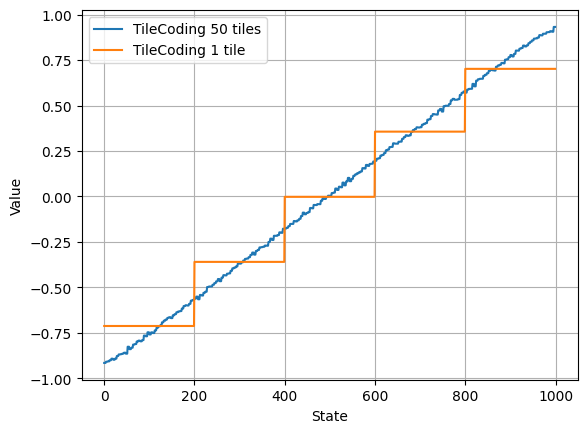

In [171]:
plt.plot(np.repeat(np.mean(t1_V, axis=0)[1:-49], 4, axis=0), label='TileCoding 50 tiles')
plt.plot(np.repeat(np.mean(t2_V, axis=0)[1:], 200, axis=0), label='TileCoding 1 tile')

plt.legend()
plt.grid()
plt.xlabel('State')
plt.ylabel('Value')
plt.show()

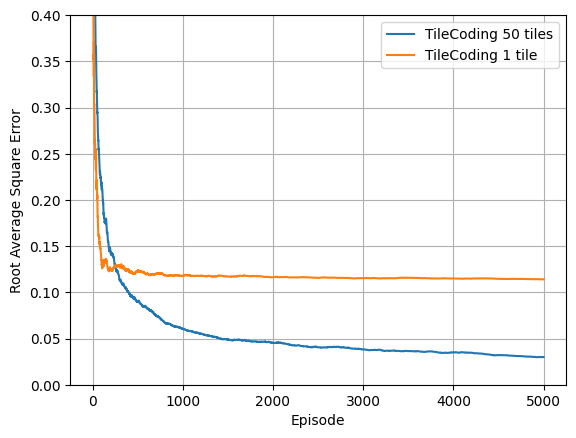

In [172]:
plt.plot(np.mean(t1_ras, axis=0), label='TileCoding 50 tiles')
plt.plot(np.mean(t2_ras, axis=0), label='TileCoding 1 tile')

plt.legend()
plt.grid()
plt.ylim(0, 0.4)
plt.xlabel('Episode')
plt.ylabel('Root Average Square Error')
plt.show()